In [ ]:
# %%html
# <script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value=" 
# Curso: Diseño y mantenimiento de instalaciones de energía solar fotovoltaica
# Alumno: Francisco Manuel Roman Gamez

# "></form>

In [6]:
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pvlib

tz = 'Europe/Madrid'
lat, lon = 40.416644, -3.703792 # madrid
# lat, lon = 36.664240, -4.458649 # mia
si= pd.date_range(start='2019-12-20 23:00:00', periods=48, freq='30T', tz=tz)
sv= pd.date_range(start='2019-06-20 23:00:00', periods=48, freq='30T', tz=tz)
# TT=si.union(sv).union(ei).union(ev)
# TT=si.union(sv)
# TT=dias


dfv = solarposition.get_solarposition(sv, lat, lon)
# remove nighttime
dfv = dfv.loc[dfv['apparent_elevation'] > 0, :]
dfv['azimut']=dfv['azimuth']-180
# dfv.plot(kind='line',x='azimut',y='apparent_elevation',figsize=(15,10));

dfi = solarposition.get_solarposition(si, lat, lon)
dfi = dfi.loc[dfi['apparent_elevation'] > 0, :]
dfi['azimut']=dfi['azimuth']-180
# dfi.plot(kind='line',x='azimut',y='apparent_elevation',figsize=(15,10));


In [7]:
dfv1=dfv[['azimut','apparent_elevation']]
dfi1=dfi[['azimut','apparent_elevation']]
# df1

In [8]:


# print (df1.to_string(index=False))
dfv2=dfv1.rename(columns={'azimut':'x','apparent_elevation':'y'}, inplace=True)
dfi2=dfi1.rename(columns={'azimut':'x','apparent_elevation':'y'}, inplace=True)


/home/pk/.env/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
ssi=dfi1.reset_index().to_json(orient='records')
ssi
parsed = json.loads(ssi)
asi=json.dumps(parsed) 
print(asi)



[{"index": 1576915200000, "x": -55.0887064636, "y": 3.51188166}, {"index": 1576917000000, "x": -49.8849133491, "y": 7.9372286194}, {"index": 1576918800000, "x": -44.3402228422, "y": 12.0839023362}, {"index": 1576920600000, "x": -38.4148768822, "y": 15.8401134505}, {"index": 1576922400000, "x": -32.0853956548, "y": 19.125391871}, {"index": 1576924200000, "x": -25.3525034457, "y": 21.8631255414}, {"index": 1576926000000, "x": -18.2491655066, "y": 23.9802498879}, {"index": 1576927800000, "x": -10.8458066725, "y": 25.4126336843}, {"index": 1576929600000, "x": -3.2491363827, "y": 26.1123746458}, {"index": 1576931400000, "x": 4.407780391, "y": 26.054587409}, {"index": 1576933200000, "x": 11.9831723765, "y": 25.2413661772}, {"index": 1576935000000, "x": 19.3469912564, "y": 23.7014397041}, {"index": 1576936800000, "x": 26.3976221608, "y": 21.4856521509}, {"index": 1576938600000, "x": 33.0704484443, "y": 18.6599412689}, {"index": 1576940400000, "x": 39.3378461083, "y": 15.2981758437}, {"index":

In [11]:
ssv=dfv1.reset_index().to_json(orient='records')
ssv
parsed = json.loads(ssv)
asv=json.dumps(parsed) 
print(asv)

[{"index": 1561093200000, "x": -119.8603800159, "y": 1.9639924627}, {"index": 1561095000000, "x": -115.1880993582, "y": 6.8488158554}, {"index": 1561096800000, "x": -110.6889685337, "y": 12.0546220222}, {"index": 1561098600000, "x": -106.298099202, "y": 17.4447334358}, {"index": 1561100400000, "x": -101.9440071837, "y": 22.9669997088}, {"index": 1561102200000, "x": -97.5443778253, "y": 28.5839192801}, {"index": 1561104000000, "x": -92.9988934288, "y": 34.2614558565}, {"index": 1561105800000, "x": -88.1774230249, "y": 39.9642950354}, {"index": 1561107600000, "x": -82.9003008732, "y": 45.6511939135}, {"index": 1561109400000, "x": -76.9046257104, "y": 51.2680089745}, {"index": 1561111200000, "x": -69.7860936535, "y": 56.7353043517}, {"index": 1561113000000, "x": -60.9027467815, "y": 61.9245855798}, {"index": 1561114800000, "x": -49.249718647, "y": 66.6122697596}, {"index": 1561116600000, "x": -33.4834020575, "y": 70.4020065469}, {"index": 1561118400000, "x": -12.8436946631, "y": 72.669502

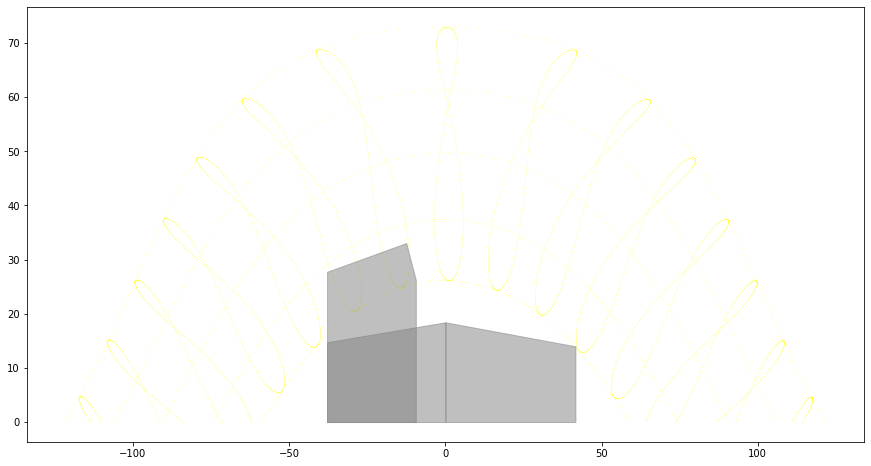

In [1]:
# proyecto='ua92-te2-03'
proyecto='ua92-te2-03'
ciudad ='Valencia'
beta=35
alfa=0

# from numpy import *
import pandas as pd
import numpy as np
# np.warnings.filterwarnings('ignore')
%matplotlib inline
np.warnings.filterwarnings('ignore')
from numpy import ones,vstack
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from pvlib import solarposition

# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
## analema

# ?grafico de posiciones

tz = 'Europe/Madrid'
lat, lon = 40.416644, -3.703792 # madrid
start='2019-01-01 00:00:00'
end='2020-01-01'
# analema
analema=pd.date_range(start+' 00:17:00', end, closed='left', freq='H', tz=tz)
# solsticios y quinocios
dias=pd.date_range(start, start, freq='1min', tz=tz)
# for date in pd.to_datetime(['2019-03-21','2019-04-21', '2019-06-21', '2019-10-27','2019-12-21']):
for date in pd.to_datetime(['2019-03-21','2019-04-21', '2019-06-21', '2019-10-25','2019-12-21']):
    dia = pd.date_range(date, date+pd.Timedelta('24h'), freq='3min', tz=tz)
    dias=dias.union(dia)
# todo    
T=analema.union(dias)
dfg = solarposition.get_solarposition(T, lat, lon)
dfg = dfg.loc[dfg['apparent_elevation'] > 0, :]
dfg = dfg.rename(columns={'apparent_elevation': 'elevacion'})
dfg["azimut"]=dfg["azimuth"]-180
# dfg
# dfg.plot(kind='scatter',x='azimuth',y='apparent_elevation',figsize=(15,10));
# calculos de los 8 punos del cubo y paso a polares

# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////



def pointIsOnLine(m, c, x, y): 
    if (y >= ((m * x) + c)):  
        return True;  
    return False;  


def pp(q):
    # def sombra(q):
    p=q[:,:3]
    v=q[:,3:6]
    t1=[0,0,0,0,1,1,1,1]
    t2=[0,0,1,1,0,0,1,1]
    t3=[0,1,0,1,0,1,0,1]
    t=np.array([t1,t2,t3])
    # 
    ones=np.eye(3, dtype=int)
    vv=v*ones
    tt=np.dot(vv,t)
    pp=np.transpose(p)+tt
    df = pd.DataFrame(pp).T
    df.columns=['s','o','h']
    df['azimut']=round(np.arctan(df.o/df.s)*180/np.pi,2)
#     sii esta en el tercer cuadrante, al amanecer
    if (df.iloc[0]['s'] < 0) & (df.iloc[0]['o'] < 0):
        df['azimut']=-180+df['azimut']
    if (df.iloc[0]['s'] < 0) & (df.iloc[0]['o'] > 0):
        df['azimut']=180+df['azimut']
    df['elevacion']=round(np.arctan(df.h/(df.s**2+df.o**2)**(1/2))*180/np.pi,2)
    df.set_index('azimut')
    df=df.sort_values(by=['elevacion'],ascending=False)

    df=df[0:3]
    df=df.sort_values(by=['azimut'],ascending=True)

    # # ax = df.plot.area()
    x1=df.iloc[0]['azimut']
    y1=df.iloc[0]['elevacion']
    x2=df.iloc[2]['azimut']
    y2=df.iloc[2]['elevacion']
    x=df.iloc[1]['azimut']
    y=df.iloc[1]['elevacion']
    # [x1,y1,x2,y2,x,y]
    points = [(x1,y1),(x2,y2)]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]


    points = [(x1,y1),(x2,y2)]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]


    # Driver code  
    # x = 2; y = 3;  

    if not (pointIsOnLine(m, c, x, y)):  
        df=df.drop(df.index[1])
    return df

# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# figura
df=pd.DataFrame()
# 
fig,ax=plt.subplots(figsize=(15,8))


# import matplotlib.image as mpimg
# image = mpimg.imread('./sombras2.png')
# ax.imshow(image,aspect='auto', extent=(-130,130,0,80), alpha=0.5, zorder=-1)

f=dfg[["azimut","elevacion"]].copy()
x=f["azimut"].tolist()
y=f["elevacion"].tolist()
ax.scatter(x,y,s=0.01,color='yellow')


# q=np.array([[9, -7, 0,7,7,3]])
# f=pp(q)
# x=f["azimut"].tolist()
# y=f["elevacion"].tolist()
# ax.fill_between(x,0,y, color='grey',alpha=0.5)


df=pd.DataFrame()
df=pd.read_csv("tablas/sombras_edificios.csv")
df=df[(df.proyecto == proyecto)]
df=df.drop(['proyecto'], axis=1)
cubos=df.to_numpy()
ff=pd.DataFrame()
for row in cubos:
    row=np.array([row])
    q=row
    f=pp(q)
    ff=ff.append(f)
    x=f["azimut"].tolist()
    y=f["elevacion"].tolist()
    ax.fill_between(x,y, color='grey',alpha=0.5)
#     ax.plot(x,y, color='grey',alpha=0.5)

# maquillado de los puntos para imprimir
# ff = ff.rename(columns={'azimut':"$\alpha $"})
ff=ff.drop(['s','o','h'], axis=1)



import os
# os.remove("plt.png")

# fig.savefig('plt.png')
# plt.close()

In [2]:
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////
# ///////////////////////////////////////////////


# calculo de las sombras
import pandas as pd
import numpy as np
# pesos


dfi=pd.DataFrame()
dfo=pd.DataFrame()


#  tasbla de irradiacion
s=pd.DataFrame()
s=pd.read_csv('tablas/sombras_coeficientes.csv', index_col=0, header=None).T
ab=s.loc[(s['a'] == str(alfa))&(s['b'] == str(beta))]
dfi  = ab.drop(['a', 'b'], axis=1)

d = pd.DataFrame(np.zeros((14, 4)))

dfi=dfi.reindex(index=dfi.index[::-1])
dfi=dfi.set_index('porc')

# tabla de ocultacon
dfo=pd.read_csv('tablas/sombras_ocultacion.csv', index_col=0, header=0)
dfo=dfo[dfo['proyecto']==proyecto]
dfo  = dfo.drop(['proyecto'], axis=1)


# marcar las porciones afectadas
def highlight(value):
    return dfo.applymap(lambda x: 'color: red' if x*10 else '')
dfs=dfi.style.apply(highlight, axis=None)

# las perdidas parciales
p=dfi.values.astype(float)*dfo.values.astype(float)/100
# solo para visualizarla tabla
dfp=dfi.copy()
dfp.loc[::]=np.array(p)
# para calcular las perdidas totales como la suma de todas las parciales
pp=np.cumsum(np.reshape(p,56))
pt=pp[len(pp)-1]

## 3.- Calcula las perdidas por sombras del ejercicio cuyo dibujo se expone, sabiendo que la ciudad donde se encuentra el edificio es Madrid y módulos a 35 º con la horizontal.

![]( 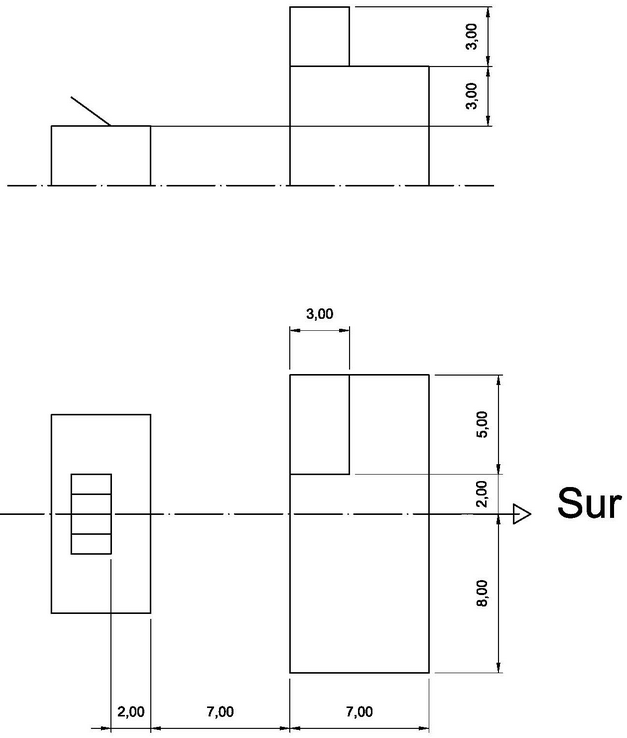)

## Respuesta
Se utiliza el  método  descrito en el Pliego de Condiciones Técnicas deInstalaciones Conectadas a Red (PCT-C-REV - julio 2011),

Segun el cual tales pérdidas se expresan como porcentaje de la radiación solar global que incidiría sobre la mencionada superficie de no existir sombra alguna. 

### Obtención del perfil de obstáculos 
Localización  de  los  principales  obstáculos  que  afectan  a  la  superficie,  en  términos  de  sus  coordenadas de posición azimut ,$\angle \alpha$ ,(ángulo de desviación con respecto a la dirección Sur) y elevación,$\angle \beta $, (ángulo de inclinación con respecto al plano horizontal). 

En nuestro caso a partir de la figura, tomando como origen de coordenadas

* C :centro de los captadores

Se define el sistema de coordenadas rectangulares 
* S (m) : horizontal sur. ( $\overrightarrow{CP}_S$) 
* O (m) : horizonal oeste.( $\overrightarrow{CP}_O$) 
* H (m) : vertical.( $\overrightarrow{CP}_H$) 

de donde se obienen:

$$
\alpha=\arctan \frac{O}{S}        \\
\beta =\arctan \frac{H}{\sqrt{S^2+O^2}}
$$


{{ff}}

Representados en el diagrama de la figura:

![alt text](plt.png "Title")

Se excoge como  referencia de irradiacion anual (%) la tabla $H_{\% irradiacion,p}$, para cada porcion, segun los ángulos de inclinación,$\beta_s$  y orientación,$\alpha_s$ 

* $\beta_s$={{beta}}$^o$
* $\alpha_s$={{alfa}}$^o$

{{dfs}}

Usando para aquellas porciones que resulten  total  o  parcialmente  ocultas  por  el  perfil  de  obstáculos  representado, los valores: 
* $\% ocultacion \in [0.25, 0.50, 0.75,1]$
se tiene la tabla $O_{\%ocultacion,p}$
{{dfo}}

combinando ambas tablas

* $Pérdidas_{\%sombreado,p}=H_{\% irradiacion,p} \cdot  O_{\%ocultacion,p}$

{{dfp}}

* $Pérdidas_{\%sombreado,Total}=\sum_{p} Pérdidas_{\%sombreado,p}$ 
> $Pérdidas_{\%sombreado,Total}=${{pt}} %

In [ ]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value=" 
Curso: Diseño y mantenimiento de instalaciones de energía solar fotovoltaica
Alumno: Francisco Manuel Roman Gamez

"></form>